In [1]:
# import important libraries 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('C:/Users/techin/bank-app-review-analysis_week2/data/cleaned_reviews.csv')
df.head()

,review,rating,date,bank,source
0,niec,5,2025-06-04,CBE,Google Play
1,best app finance,5,2025-06-04,CBE,Google Play
2,yetemeta,1,2025-06-03,CBE,Google Play
3,engida kebede fetera,5,2025-06-03,CBE,Google Play
4,good,5,2025-06-03,CBE,Google Play


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Sentiment Analysis 
## TextBlob

In [5]:
from textblob import TextBlob
import pandas as pd

def get_sentiment(text):
    try:
        if pd.isnull(text) or not str(text).strip():
            return 'neutral'  # or 'unknown'
        analysis = TextBlob(str(text))
        polarity = analysis.sentiment.polarity
        if polarity > 0:
            return 'positive'
        elif polarity < 0:
            return 'negative'
        else:
            return 'neutral'
    except Exception as e:
        return 'neutral'  # fallback for unexpected errors

# Apply sentiment analysis safely
df['sentiment'] = df['review'].apply(get_sentiment)

# View results
print(df['sentiment'].value_counts())

sentiment
positive    3629
neutral     2340
negative     710
Name: count, dtype: int64


In [6]:
# Calculate sentiment counts per bank
sentiment_counts = df.groupby(['bank', 'sentiment']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions)

sentiment  negative   neutral  positive
bank                                   
BOA        0.237327  0.362903  0.399770
CBE        0.088437  0.359297  0.552266
Dashen     0.064039  0.204433  0.731527


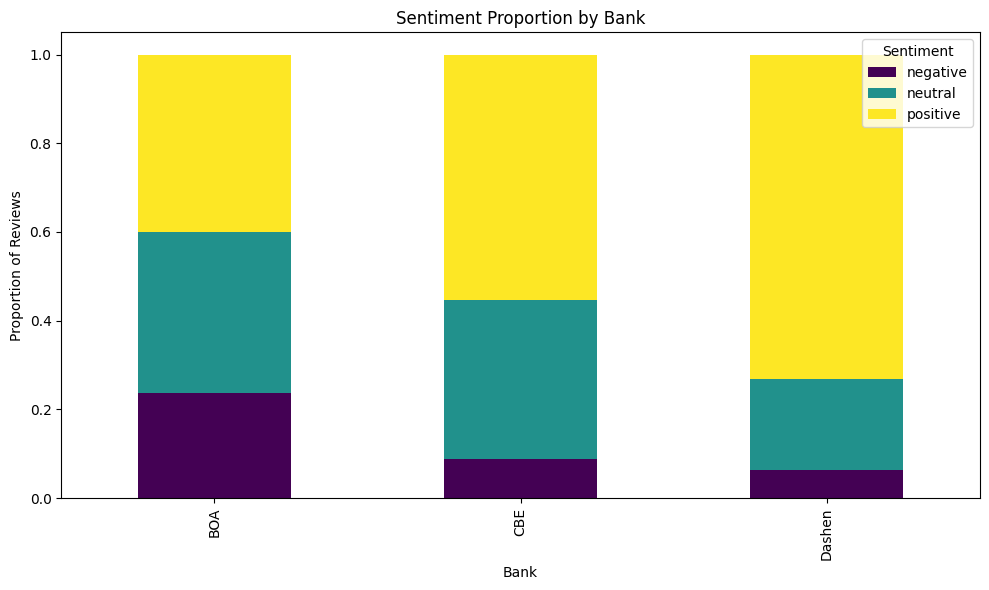

In [7]:
import matplotlib.pyplot as plt

# Plot proportions
sentiment_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Sentiment Proportion by Bank')
plt.xlabel('Bank')
plt.ylabel('Proportion of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

## Vader

In [8]:

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Handle NaN and ensure string input
df['compound_score'] = df['review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Convert score to label
def get_sentiment_label(score):
    if score >= 0.05:
        return 'posetive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiments'] = df['compound_score'].apply(get_sentiment_label)

# Save output
df['sentiments'].value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiments
posetive    3794
neutral     2082
negative     803
Name: count, dtype: int64

In [9]:
# Calculate sentiment counts per bank
sentiment_counts = df.groupby(['bank', 'sentiments']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions)

sentiments  negative   neutral  posetive
bank                                    
BOA         0.252304  0.328341  0.419355
CBE         0.105273  0.315819  0.578908
Dashen      0.036946  0.221675  0.741379


## Machine learning aproach(Naive bayes)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Create labels based on ratings
df['label'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

# Vectorize text
vectorizer =  TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.7709580838323353


In [11]:
df['predicted_sentiment'] = clf.predict(X)

# Count and display the number of reviews per sentiment
sentiment_counts = df['predicted_sentiment'].value_counts()
print(sentiment_counts)

predicted_sentiment
positive    5306
negative    1366
neutral        7
Name: count, dtype: int64


In [12]:
# Calculate sentiment counts per bank
sentiment_counts = df.groupby(['bank', 'predicted_sentiment']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions)

predicted_sentiment  negative   neutral  positive
bank                                             
BOA                  0.397465  0.000000  0.602535
CBE                  0.182794  0.001295  0.815911
Dashen               0.081281  0.000000  0.918719


# Key word extraction

In [13]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['review'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['access' 'account' 'add' 'also' 'always' 'amazing' 'app' 'application'
 'apps' 'bad' 'balance' 'bank' 'banking' 'best' 'better' 'birr' 'branch'
 'ca' 'cbe' 'code' 'could' 'customer' 'dashen' 'day' 'developer' 'easy'
 'error' 'ethiopia' 'even' 'ever' 'every' 'excellent' 'experience' 'fast'
 'feature' 'fix' 'friendly' 'get' 'go' 'good' 'great' 'help' 'history'
 'issue' 'keep' 'life' 'like' 'love' 'make' 'mobile' 'money' 'much' 'need'
 'network' 'new' 'nice' 'one' 'open' 'option' 'payment' 'phone' 'please'
 'poor' 'previous' 'problem' 'properly' 'really' 'recent' 'say' 'see'
 'send' 'service' 'show' 'simple' 'sometimes' 'super' 'system' 'thank'
 'thanks' 'thing' 'time' 'transaction' 'transfer' 'try' 'update' 'updated'
 'use' 'used' 'user' 'using' 'verification' 'version' 'well' 'work'
 'working' 'worst' 'would' 'wow' 'በጣም' 'ነው']


In [12]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(2,3))
X = vectorizer.fit_transform(df['review'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['amazing app' 'app easy' 'app easy use' 'app ethiopia' 'app ever'
 'app ever seen' 'app fast' 'app good' 'app keep' 'app like' 'app make'
 'app thanks' 'app use' 'app work' 'app working' 'authorization code'
 'bad app' 'bank ethiopia' 'bank super' 'banking app' 'banking app ever'
 'banking system' 'best app' 'best application' 'best bank' 'best best'
 'best mobile' 'best mobile banking' 'better previous' 'ca use' 'cbe app'
 'cbe birr' 'cbe mobile' 'commercial bank' 'commercial bank ethiopia'
 'customer service' 'dashen bank' 'dashen super' 'dashen super app'
 'developer mode' 'developer option' 'easy fast' 'easy use'
 'error message' 'ever seen' 'every time' 'excellent app' 'fast easy'
 'fix bug' 'get verification' 'go bank' 'good app' 'good application'
 'good job' 'good service' 'good work' 'great app' 'keep crashing'
 'last update' 'latest update' 'life easy' 'like app' 'love app'
 'make life' 'make transaction' 'mobile app' 'mobile banking'
 'mobile banking app' 'nee

In [14]:
# Filter positive and negative reviews
positive_reviews = df[df['sentiments'] == 'posetive']['review']
negative_reviews = df[df['sentiments'] == 'negative']['review']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(max_features=10,ngram_range=(2,3), stop_words='english')
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(max_features=15,ngram_range=(2,3), stop_words='english')
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

Top Keywords in Positive Reviews: ['banking app' 'best app' 'dashen bank' 'easy use' 'good app' 'great app'
 'mobile banking' 'mobile banking app' 'nice app' 'user friendly']
Top Keywords in Negative Reviews: ['app seen' 'app work' 'bad app' 'banking app' 'developer option'
 'error message' 'mobile banking' 'mobile banking app' 'new update'
 'poor app' 'recent transaction' 'use app' 'worst app' 'worst mobile'
 'worst mobile banking']


In [15]:
# Filter negative reviews only
negative_reviews = df[df['sentiments'] == 'negative']
banks = negative_reviews['bank'].unique()

# Loop through each bank and extract top negative key phrases
for bank in banks:
    print(f"\nTop Negative Key Phrases for {bank}:")
    
    # Get only negative reviews for this bank
    bank_reviews = negative_reviews[negative_reviews['bank'] == bank]['review']
    
    # Vectorize using bigrams/trigrams
    vectorizer = TfidfVectorizer(max_features=20, ngram_range=(2, 3))
    X = vectorizer.fit_transform(bank_reviews)
    
    # Print top phrases
    top_phrases = vectorizer.get_feature_names_out()
    print(top_phrases)


Top Negative Key Phrases for CBE:
['app ever' 'bad app' 'error message' 'ever seen' 'every time'
 'fix problem' 'last update' 'mobile banking' 'new update'
 'none available' 'please fix' 'poor app' 'recent transaction'
 'show error' 'transaction history' 'use app' 'using app'
 'verification code' 'worst app' 'worst app ever']

Top Negative Key Phrases for BOA:
['app crash' 'app ever' 'bad app' 'banking app' 'banking app ever'
 'ca even' 'developer option' 'every time' 'make transaction'
 'mobile banking' 'mobile banking app' 'open app' 'please fix' 'poor app'
 'useless app' 'worst app' 'worst app ever' 'worst banking app'
 'worst mobile' 'worst mobile banking']

Top Negative Key Phrases for Dashen:
['app close' 'app close frequently' 'app ever' 'worst app' 'ነው ነገር ግን'
 'ነገር ግን' 'ነገር ግን ብር' 'አለበት አሱ' 'አለበት አሱ ቢስተካከል' 'አለው ሁሉ' 'አለው ሁሉ ጊዜ'
 'አሱ ቢስተካከል' 'አሱ ቢስተካከል star' 'አስከዛው ግን' 'አስከዛው ግን ሰጥቻለው'
 'የሚገርም aplication' 'የሚገርም aplication ነው' 'ያለ ፒን' 'ያለ ፒን መሆኑ' 'ጊዜ ትራንስፈር']


In [16]:
# Filter negative reviews only
negative_reviews = df[df['predicted_sentiment'] == 'negative']
banks = negative_reviews['bank'].unique()

# Loop through each bank and extract top negative key phrases
for bank in banks:
    print(f"\nTop Negative Key Phrases for {bank}:")
    
    # Get only negative reviews for this bank
    bank_reviews = negative_reviews[negative_reviews['bank'] == bank]['review']
    
    # Vectorize using bigrams/trigrams
    vectorizer = TfidfVectorizer(max_features=20, ngram_range=(2, 3))
    X = vectorizer.fit_transform(bank_reviews)
    
    # Print top phrases
    top_phrases = vectorizer.get_feature_names_out()
    print(top_phrases)


Top Negative Key Phrases for CBE:
['app ever' 'app working' 'bad app' 'developer mode' 'developer option'
 'error message' 'every time' 'go bank' 'last update' 'new update'
 'none available' 'please fix' 'recent transaction' 'transaction history'
 'update app' 'use app' 'verification code' 'work properly'
 'working properly' 'worst app']

Top Negative Key Phrases for BOA:
['app ever' 'bad app' 'banking app' 'developer option' 'disable developer'
 'every time' 'fix bug' 'make transaction' 'mobile banking'
 'mobile banking app' 'please fix' 'poor app' 'turn developer' 'use app'
 'useless app' 'working properly' 'worst app' 'worst app ever'
 'worst mobile' 'worst mobile banking']

Top Negative Key Phrases for Dashen:
['app ever' 'app working' 'make transaction' 'need improvement' 'need otp'
 'recent transaction' 'super app' 'working properly' 'ለመላክ አይሰራም'
 'ለመላክ አይሰራም ሁለተኛ' 'መጠየቅ ያለበት' 'መጠየቅ ያለበት ይመስለኛል' 'ሞባይል ነበር' 'ሞባይል ነበር ነዉ'
 'ነበር ነዉ' 'ነበር ነዉ መጠየቅ' 'ነዉ መጠየቅ' 'ነዉ መጠየቅ ያለበት' 'አይሰራም ሁለተ

## K means clustering 

In [17]:
theme_results = []

for bank in df['bank'].unique():
    bank_reviews = df[df['bank'] == bank]
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    X = tfidf.fit_transform(bank_reviews['review'])

    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(X)
    clusters = kmeans.labels_

    bank_reviews = bank_reviews.copy()
    bank_reviews['theme'] = clusters
    theme_results.append(bank_reviews)

# Combine all banks
df_with_themes = pd.concat(theme_results)

# Optional: Label top words in each theme
def get_top_keywords_per_cluster(tfidf_matrix, labels, features, n_terms=5):
    cluster_keywords = {}
    for cluster_num in set(labels):
        mean_tfidf = tfidf_matrix[labels == cluster_num].mean(axis=0)
        top_idx = mean_tfidf.argsort()[0, -n_terms:].tolist()[0]
        cluster_keywords[cluster_num] = [features[i] for i in top_idx[::-1]]
    return cluster_keywords

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Example setup
bank_df = df[df['bank'] == 'BOA']  # or any specific bank
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(bank_df['review'])
features = vectorizer.get_feature_names_out()

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
bank_df['cluster'] = kmeans.labels_

# Show top keywords for each cluster
print("\nTop Keywords per Cluster:")
for i in range(5):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    top_words = [features[j] for j in top_indices]
    print(f"Cluster {i}: {', '.join(top_words)}")


Top Keywords per Cluster:
Cluster 0: app, bank, best, boa, nice, time, like, use, update, bad
Cluster 1: working, app, properly, need, update, day, phone, screenshot, best, open
Cluster 2: banking, mobile, app, worst, boa, use, work, bank, best, time
Cluster 3: good, app, application, service, new, bank, update, boa, user, really
Cluster 4: work, app, good, update, bank, feature, bad, device, need, crash


C:\Users\techin\AppData\Local\Temp\ipykernel_10764\3469162791.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_df['cluster'] = kmeans.labels_


In [25]:
print("\nSample Reviews per Cluster:")
for i in range(5):
    print(f"\nCluster {i} Reviews:")
    sample_reviews = bank_df[bank_df['cluster'] == i]['review'].head(4)  # change to 5 if needed
    for review in sample_reviews:
        print(f" - {review}")


Sample Reviews per Cluster:

Cluster 0 Reviews:
 - hello facing problem boa mobile app every time enter phone number password app crash show error say boamobile closed app tried updating reinstalling clearing cache nothing worked please fix bug next update really need access account thank
 - exceptional
 - worest app loading
 - app interest android phone please update

Cluster 1 Reviews:
 - app working asked password start loading open
 - version working even buy card send money
 - working day
 - need support app working

Cluster 2 Reviews:
 - boa mobile good bank
 - boa mobile backing
 - work period z slowest mobile banking ever would rather use 815
 - went bank many time could make transaction see balance nothing else point mobile banking ca make transaction please work

Cluster 3 Reviews:
 - good service
 - good
 - excellent app
 - liking application good

Cluster 4 Reviews:
 - app joke crash work take forever load half feature decorative point log transfer money even check balance